In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns; sns.set()
import warnings
import gc


#import time
#import psutil
#import multiprocessing as mp

# enable garbage collector to aid in memory 
gc.enable()
# eliminate future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
prior = pd.read_csv("order_products__prior.csv")
train = pd.read_csv("order_products__train.csv")
products = pd.read_csv("products.csv")

In [3]:
prior_orders = orders.loc[orders['eval_set'] == 'prior']

In [4]:
prior_products = prior.merge(orders, on = 'order_id', how = 'left')

In [5]:
prior_products.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


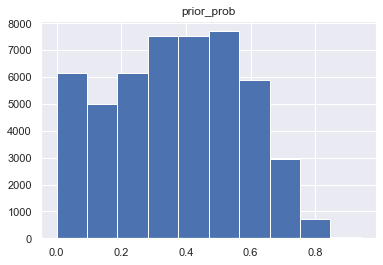

In [6]:
# We calculate the overall percentage of reorders for
# each product
product_prior_dist = pd.DataFrame(
    # Number of times product was reordered
    prior_products.groupby('product_id')['reordered'].sum()
    /
    # Total number of times product was ordered
    prior_products.groupby('product_id').size()
)

# Rename the column
product_prior_dist.columns = ['prior_prob']

# Most products are reordered between 0 and 50%
# of the time, with a tail of higher percentages
product_prior_dist.hist()
plt.show()

In [7]:
# For all users, for every product they've ordered,
# count how many times they've ordered it
products_ordered = (
    prior_products
    .groupby(['user_id', 'product_id'])
    .size()
    .reset_index()
    .rename(columns={0:'times_ordered'})
)

# For all users, count their number of orders
number_of_orders = pd.DataFrame(
    prior_products
    .groupby(['user_id'])['order_id']
    .nunique()
).reset_index().rename(columns={'order_id':'total_user_orders'})

# Merge
product_dist_per_user = products_ordered.merge(
    number_of_orders, 
    how = 'left', 
    on = 'user_id'
)

# Get product ordering probability per user
product_dist_per_user['product_prob_user'] = (
    product_dist_per_user['times_ordered']
    /product_dist_per_user['total_user_orders']
)

# Add in the overall ordering probabilities
product_prob = product_dist_per_user.merge(
    product_prior_dist, 
    how = 'left', 
    left_on = 'product_id', 
    right_index = True)

# Calculate reordering score p
product_prob['p'] = (
    product_prob['product_prob_user']
    *product_prob['prior_prob']
    /(1-product_prob['product_prob_user'])
)

product_prob.head(3)

,user_id,product_id,times_ordered,total_user_orders,product_prob_user,prior_prob,p
0,1,196,10,10,1.0,0.776480,inf
1,1,10258,9,10,0.9,0.713772,6.423947
2,1,10326,1,10,0.1,0.652009,0.072445


In [8]:
# Get the orders in the training set for which
# we need predictions
orders_train = orders[orders['eval_set'] == 'train']

# Import the products and add to the data
products_train = train.merge(
    orders_train, 
    how = 'left', 
    on = 'order_id')

# We only need to predict reordered products, not
# products that are ordered for the first time
products_train = products_train[products_train['reordered']==1]
products_train.head(3)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [9]:
# We don't want a row for every product, but one
# row per order with a list of the reordered products
reordered_train = products_train[['order_id', 'product_id']].groupby('order_id')['product_id'].apply(list)

# Put the user_id of the orders back in; we'll need it
# to get the user-dependent ordering probabilities
reordered_train = pd.DataFrame(reordered_train).merge(
    orders_train[['order_id','user_id']], 
    how = 'left', 
    right_on = 'order_id', 
    left_index = True
)

reordered_train.head(3)

,product_id,order_id,user_id
1868044,"[49302, 11109, 43633, 22035]",1,112108
1322255,"[19660, 43086, 46620, 34497, 48679, 46979]",36,79431
709772,[21616],38,42756


In [10]:
# Helper functions to calculate the F1 score
def precision(truth, pred):
    true_positives = set(truth).intersection(pred)
    false_positives = set(pred) - set(truth)
    num_true = len(true_positives)
    num_false = len(false_positives)
    if (num_true + num_false == 0):
        return 1
    else:
        return num_true/(num_true+num_false)
    
def recall(truth, pred):
    true_positives = set(truth).intersection(pred)
    false_negatives = set(truth) - set(pred)
    num_true = len(true_positives)
    num_false = len(false_negatives)
    if (num_true + num_false == 0):
        return 1
    else:
        return num_true/(num_true+num_false)
    
def f1_score(truth, pred):
    p = precision(truth, pred)
    r = recall(truth, pred)
    if( p+r == 0 ):
        return 0
    else:
        return 2*p*r/(p+r)

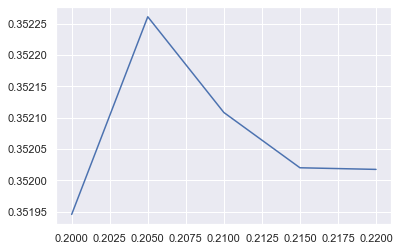

In [11]:
# Optimize the threshold value
thresholds = [0.2,0.205,0.21,0.215,0.22]
scores = []
for t in thresholds:
    pred = (
        product_prob[product_prob['p'] > t]
        .groupby('user_id')['product_id']
        .apply(list)
    )
    reordered_pred_train = reordered_train.merge(
        pd.DataFrame(pred), 
        how='left', 
        left_on='user_id', 
        right_index = True
    )
    reordered_pred_train.fillna('None', inplace=True)
    reordered_pred_train['f1'] = reordered_pred_train.apply(
        lambda row: f1_score(
            row['product_id_x'], 
            row['product_id_y']
        ), 
        axis=1)
    scores.append(reordered_pred_train['f1'].mean())
    
plt.plot(thresholds, scores)
plt.show()